# prologue

In [1]:
# for notebook plotting
%matplotlib inline 

# load what we need
import time
import timeit
import numpy as np
import CHIRPS.structures as strcts
import CHIRPS.datasets as ds
import CHIRPS.datasets_proprietary as dsp
import CHIRPS.routines as rt

# demo datasets that ship with package. all from UCI unless stated otherwise
# import CHIRPS.datasets as ds
# ds.adult_data, ds.adult_samp_data, ds.adult_small_samp_data Large dataset ships with manageable sub samples
# ds.bankmark_data, ds.bankmark_samp_data
# ds.car_data
# ds.cardio_data this is the cardiotocography dataset
# ds.credit_data
# ds.german_data
# ds.lending_data, ds.lending_samp_data, ds.lending_small_samp_data, ds.lending_tiny_samp_data from Kaggle. see datasets_from_source file for links
# ds.nursery_data, ds.nursery_samp_data
# ds.rcdv_data, ds.rcdv_samp_data from US government see datasets_from_source file for links

### set up notebook and load package

### common config - can be ommitted if defaults are OK

In [2]:
# location to save results
project_dir = '/datadisk/whiteboxing/examples2'
# project_dir = 'V:\\whiteboxing\\2020' # defaults to a directory "whiteboxing" in the working directory
# project_dir = 'C:\\Users\\Crutt\\Documents\\whiteboxing\\2020'

random_state_splits = 123 # one off for splitting the data into test / train
random_state = 123 # for everything else - e.g. building a new rf with same data

# Build a Random Forest Model to Predict and Explain
First, a wrapper is created for the dataset. Use one that ships with the package, or create your own.
Then split the data into training and (hold out) test set using the convenience functions in the package. These return an object that contain the split data in various representations, such as Pandas DataFrames and encoded, sparse matrices.

/home/julianhatwell/anaconda3/envs/B3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


using previous tuning parameters
Best OOB Accuracy Estimate during tuning: 0.7586
Best parameters:{'max_depth': 32.0, 'n_estimators': 1600, 'oob_score': True, 'random_state': 123}

Confusion matrix, without normalization
[[193  19]
 [ 46  42]]


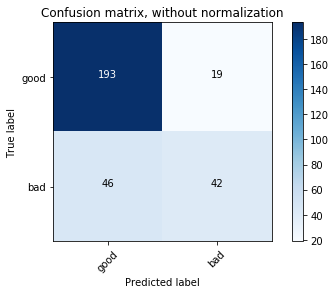

Normalized confusion matrix
[[0.91 0.09]
 [0.52 0.48]]


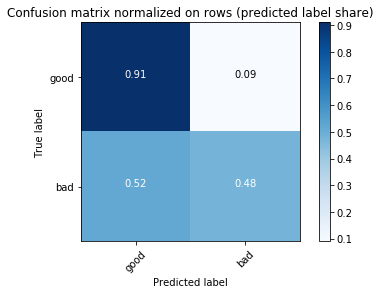

In [3]:
# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
override_tuning = False
mydata = ds.german(random_state=random_state_splits, project_dir=project_dir)

meta_data = mydata.get_meta()
save_path = meta_data['get_save_path']()

# split the data. here using a basic sampling method.
# the returned object is a wrapper class that contains
# the train and test splits for X and y

# also the the encoded versions of X_train and X_test that the rf will use
# this is because we prefer onehot encoded over allowing categorical vars to be represented as integer
# scikit would treat these as ordinal, which is inappropriate

# also some meta-data: priors for y, the indexes from the input data

# also some convenience functions for leave-one-out testing

# train test split - one off hard-coded random state.
# random state can be ommitted 
# and will default to the state held in the dataset container
# which defaults to 123 if ommitted in the constructor
train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# CHOOSE ONE
model = 'RandomForest'
# model = 'AdaBoost1' # SAMME
# model = 'AdaBoost2' # SAMME.R
# model = 'GBM'

# decide if to run the whole tuning routine again (long for Adaboost)
# RF routine has a default tuning grid, so can leave as None, or come up with some other options
tuning = {'grid' : None, 'override' : override_tuning}
if model == 'RandomForest':
    which_trees = 'majority'
    tuning.update({'grid' : {'n_estimators': [(i + 1) * 200 for i in range(8)],
                            'max_depth' : [32]}})

elif model in ('AdaBoost1', 'AdaBoost2'):
    if model == 'AdaBoost1':
        # classic (and multi-class) AdaBoost
        algo = 'SAMME'
        which_trees = 'majority'
    else:
        # real-valued AdaBoost
        algo = 'SAMME.R'
        which_trees = 'conf_weighted'
    max_depth = [i for i in range(1, 5)]
    tuning.update({'grid' : {'base_estimator' : [rt.DecisionTreeClassifier(max_depth=d) for d in max_depth],
                            'n_estimators': [(i + 1) * 200 for i in range(8)], 'algorithm': [algo]}})
    
else: # GBM
    tuning.update({'grid' : {'subsample' : [0.5],
                        'n_estimators': [i * 200 for i in range(1, 9)],
                        'max_depth' : [i for i in range(1, 5)],
                        'learning_rate': np.full(4, 10.0)**[i for i in range(-3, 1)]}})

rf = rt.forest_prep(ds_container=tt,
                    meta_data=meta_data,
                    override_tuning=override_tuning,
                    model=model,
                    tuning_grid=tuning['grid'],
                    save_path=save_path,
                    plot_cm=True, plot_cm_norm=True)

# get what the model predicts on the training sample
sample_labels = rf.predict(tt.X_train_enc)

# Preparing unseen data

Again note:
test set has never been "seen" by random forest during training
test set has been only used to assess model (random forest) accuracy - no additional tuning after this
test set has not be involved in generating the explainer

## optional: memory and computation cost management
#### CHIRPS is time economical but memory intensive to compute for lots of instances at once
option 1: choose a smaller number of instances to explain

In [4]:
# control for async processes - each tree walk can be done in its own core
# and so can each explanation (e.g. rule conditions merge by hill-climbing)
# these will default to false if not passed explicitly to the explainer function
# on a multi-core machine there should be a good speed up for large batches
# when the batch_size advantage exceeds the overhead of setting up multi-processing
# timings will be printed to screen so you can see if it helps
forest_walk_async=True
explanation_async=True

# how many instances to explain in total from a test/unseen set
# doesn't matter if you don't know how large the dataset is
# this function prevents you maxing out, or put n_instances = None for whole dataset
n_instances = rt.n_instance_ceiling(ds_container=tt, n_instances=30)

# this gets the next batch out of the data_split_container according to the required number of instances
# all formats can be extracted, depending on the requirement
# unencoded, encoded (sparse matrix is the type returned by scikit), ordinary dense matrix also available
tt.current_row_test = 0
instances, _, instances_enc, instances_enc_matrix, labels = tt.get_next(n_instances, which_split='test') # default

option 2: just run the whole test set

In [5]:
# instances = tt.X_test; instances_enc = tt.X_test_enc; instances_enc_matrix = tt.X_test_enc_matrix; labels = tt.y_test

## Make predictions from the decision forest on the unseen data
Important point, no compromise on model accuracy

In [6]:
# get all the model predictions for the test instance(s) we're looking at
preds_idx = labels.index
preds = rf.predict(X=instances_enc)

# CHIRPS Step 1:
## Extract Tree Prediction Paths
### Fit a forest_walker object to the dataset and decision forest
This is a wrapper will extracts the paths of all the given instances. For CHIRPS, we want a large sample. The whole training set or other representative sample will do.

It can also report interesting statistics (treating the forest as a set of random tree-structured variables).

In [7]:
# wrapper object needs the decision forest itself and the dataset meta data 
if model == 'GBM':
    f_walker = strcts.regression_trees_walker(forest = rf, meta_data=meta_data)
else:
    f_walker = strcts.classification_trees_walker(forest = rf, meta_data=meta_data)

In [8]:
print('Walking forest for ' + str(len(labels)) + ' instances... (please wait)')

# set the timer
forest_walk_start_time = timeit.default_timer()

# do the walk - creates a paths_container (even for just one instance) as a new property
# requires the X instances in a matrix (dense, ordinary numpy matrix) - this is available in the data_split_container
f_walker.forest_walk(instances = instances_enc_matrix
                    , labels = preds # we're explaining the prediction, not the true label!
                    , forest_walk_async = forest_walk_async)

# stop the timer
forest_walk_end_time = timeit.default_timer()
forest_walk_elapsed_time = forest_walk_end_time - forest_walk_start_time

print('Forest Walk with async = ' + str(forest_walk_async))
print('Forest Walk time elapsed:', "{:0.4f}".format(forest_walk_elapsed_time), 'seconds')

Walking forest for 30 instances... (please wait)
Forest Walk with async = True
Forest Walk time elapsed: 2.0822 seconds


# CHIRPS Steps 2-4: 
## Freqent pattern mining of paths.
## Score and sort mined path segments.
## Merge path segments into one rule.

This is a wrapper object that will execute steps 2-4 on all the instance-paths in the batch_paths_container.

Note that true_divide warnings are OK. It just means that a continuous variable is unbounded in some way i.e. no greater/less than discontinuity is used in the CHIRPS explanation.

Note also, here we are using the training set to create the explainers. We could use a different dataset as long as it is representative of the training set that built the decision forest. Most important that we don't use the dataset that we wish to explain.

In [9]:
if model == 'GBM':
    # create a GBHIPS container object for the forest path detail
    explanations = strcts.GBHIPS_container(f_walker.path_detail,
                                    forest=rf,
                                    sample_instances=tt.X_train_enc, # any representative sample can be used
                                    sample_labels=sample_labels,
                                    meta_data=meta_data)
    
    print('Running GBHIPS on a batch of ' + str(len(labels)) + ' instances... (please wait)')
    # start a timer
    ce_start_time = timeit.default_timer()

    # run the explanation algorithm for Gradient Boosted Trees on all the instance path details
    explanations.run_explanations(target_classes=preds, # we're explaining the prediction, not the true label!
                            explanation_async=explanation_async,
                            random_state=random_state,
                            paths_lengths_threshold=5,
                            which_trees='targetclass',
                            alpha_paths=0.0,
                            support_paths=0.05,
                            score_func=1,
                            precis_threshold=0.99,
                            disc_path_bins=4,
                            merging_bootstraps=20,
                            pruning_bootstraps=20,
                            delta=0.2,
                            weighting='kldiv')
    
    # For unbalanced data in binary classification, if an instance has a negative margin, 
    # that means it moved towards the boundary (say prob = 0.5 or lodds = 0)
    # but did not move far enough to change class (say from > 0.75 prior).
    # However, one can say it has some similarities to the other class.
    # These can be viewed by setting the other class as the target and 
    # which_trees = 'signdelta' (trees that agree with the sign of the total change of lodds)

    ce_end_time = timeit.default_timer()
    ce_elapsed_time = ce_end_time - ce_start_time
    print('GBHIPS time elapsed:', "{:0.4f}".format(ce_elapsed_time), 'seconds')
    print('GBHIPS with async = ' + str(explanation_async))
    
if model == 'RandomForest':
    # create a CHIRPS container for the forest path detail
    explanations = strcts.CHIRPS_container(f_walker.path_detail,
                                    forest=rf,
                                    sample_instances=tt.X_train_enc, # any representative sample can be used
                                    sample_labels=sample_labels,
                                    meta_data=meta_data)
    
    print('Running CHIRPS on a batch of ' + str(len(labels)) + ' instances... (please wait)')
    # start a timer
    ce_start_time = timeit.default_timer()
    
    # run the explanation algorithm for Random Forest or AdaBoost on all the instance path details
    explanations.run_explanations(target_classes=preds, # we're explaining the prediction, not the true label!
                            explanation_async=explanation_async,
                            random_state=random_state,
                            which_trees=which_trees,
                            alpha_paths=0.0,
                            support_paths=0.02,
                            score_func=1,
                            precis_threshold=0.99,
                            disc_path_bins=4,
                            merging_bootstraps=20,
                            pruning_bootstraps=20,
                            delta=0.2,
                            weighting='nothing')

    ce_end_time = timeit.default_timer()
    ce_elapsed_time = ce_end_time - ce_start_time
    print('CHIRPS time elapsed:', "{:0.4f}".format(ce_elapsed_time), 'seconds')
    print('CHIRPS with async = ' + str(explanation_async))
    
if model == 'AdaBoost1':
    # create a CHIRPS container for the forest path detail
    explanations = strcts.CHIRPS_container(f_walker.path_detail,
                                    forest=rf,
                                    sample_instances=tt.X_train_enc, # any representative sample can be used
                                    sample_labels=sample_labels,
                                    meta_data=meta_data)
    
    print('Running CHIRPS on a batch of ' + str(len(labels)) + ' instances... (please wait)')
    # start a timer
    ce_start_time = timeit.default_timer()
    
    # run the explanation algorithm for Random Forest or AdaBoost on all the instance path details
    explanations.run_explanations(target_classes=preds, # we're explaining the prediction, not the true label!
                            explanation_async=explanation_async,
                            random_state=random_state,
                            which_trees=which_trees,
                            alpha_paths=0.0,
                            support_paths=0.01,
                            score_func=1,
                            precis_threshold=0.99,
                            disc_path_bins=4,
                            merging_bootstraps=20,
                            pruning_bootstraps=20,
                            delta=0.2,
                            weighting='kldiv')

    ce_end_time = timeit.default_timer()
    ce_elapsed_time = ce_end_time - ce_start_time
    print('CHIRPS time elapsed:', "{:0.4f}".format(ce_elapsed_time), 'seconds')
    print('CHIRPS with async = ' + str(explanation_async))
    
if model == 'AdaBoost2':
    # create a CHIRPS container for the forest path detail
    explanations = strcts.CHIRPS_container(f_walker.path_detail,
                                    forest=rf,
                                    sample_instances=tt.X_train_enc, # any representative sample can be used
                                    sample_labels=sample_labels,
                                    meta_data=meta_data)
    
    print('Running CHIRPS on a batch of ' + str(len(labels)) + ' instances... (please wait)')
    # start a timer
    ce_start_time = timeit.default_timer()
    
    # run the explanation algorithm for Random Forest or AdaBoost on all the instance path details
    explanations.run_explanations(target_classes=preds, # we're explaining the prediction, not the true label!
                            explanation_async=explanation_async,
                            random_state=random_state,
                            which_trees=which_trees,
                            alpha_paths=0.00,
                            support_paths=0.001,
                            score_func=1,
                            precis_threshold=0.99,
                            disc_path_bins=8,
                            merging_bootstraps=20,
                            pruning_bootstraps=20,
                            delta=0.2,
                            weighting='kldiv')

    ce_end_time = timeit.default_timer()
    ce_elapsed_time = ce_end_time - ce_start_time
    print('CHIRPS time elapsed:', "{:0.4f}".format(ce_elapsed_time), 'seconds')
    print('CHIRPS with async = ' + str(explanation_async))

Running CHIRPS on a batch of 30 instances... (please wait)
len self.path_detail
30
as_chirps for batch_idx 0
start mining for batch_idx 0 with support = 0.02


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1553: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1558: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


as_chirps for batch_idx 1
start mining for batch_idx 1 with support = 0.02


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1553: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1553: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin



start merge rule for batch_idx 0 (606) patterns

/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1558: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1558: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


as_chirps for batch_idx 2
start mining for batch_idx 2 with support = 0.02
found 606 patterns from 1183 trees for batch_idx 0
start score sort for batch_idx 0 (606) patternsas_chirps for batch_idx 3
start mining for batch_idx 3 with support = 0.02


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1553: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin


reduced 7 patterns out of 1694 by numeric redundancy
found 1687 patterns from 867 trees for batch_idx 1
start score sort for batch_idx 1 (1687) patterns
start merge rule for batch_idx 1 (1687) patterns
found 764 patterns from 913 trees for batch_idx 2
start score sort for batch_idx 2 (764) patterns
start merge rule for batch_idx 2 (764) patterns


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1558: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


as_chirps for batch_idx 4
start mining for batch_idx 4 with support = 0.02


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1553: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1558: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


reduced 1 patterns out of 558 by numeric redundancy
found 557 patterns from 1416 trees for batch_idx 3
start score sort for batch_idx 3 (557) patterns
start merge rule for batch_idx 3 (557) patterns
as_chirps for batch_idx 5
start mining for batch_idx 5 with support = 0.02


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1558: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1553: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin


found 384 patterns from 1225 trees for batch_idx 4
start score sort for batch_idx 4 (384) patterns
start merge rule for batch_idx 4 (384) patterns
as_chirps for batch_idx 6
start mining for batch_idx 6 with support = 0.02


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1553: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1558: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


as_chirps for batch_idx 7
start mining for batch_idx 7 with support = 0.02


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1558: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1553: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin


found 1327 patterns from 889 trees for batch_idx 6
start score sort for batch_idx 6 (1327) patterns
start merge rule for batch_idx 6 (1327) patterns
reduced 1 patterns out of 1031 by numeric redundancy
found 1030 patterns from 872 trees for batch_idx 7
start score sort for batch_idx 7 (1030) patterns
start merge rule for batch_idx 7 (1030) patterns
[('chk_A11', True, 0.5), ('pps_A40', True, 0.5)]
0.7820823244552058 0.3419576478166349 0.039854664849977246 0.058105881829110674
merge complete for batch_idx 2 (764) patterns
start get explainer for batch_idx 2
as_chirps for batch_idx 8
start mining for batch_idx 8 with support = 0.02
found 1149 patterns from 1139 trees for batch_idx 5
start score sort for batch_idx 5 (1149) patterns
start merge rule for batch_idx 5 (1149) patterns
found 530 patterns from 1071 trees for batch_idx 8
start score sort for batch_idx 8 (530) patterns
start merge rule for batch_idx 8 (530) patterns
[('chk_A11', False, 0.5), ('crhis_A34', True, 0.5), ('pps_A41', Tr

start score sort for batch_idx 22 (1036) patterns
start merge rule for batch_idx 22 (1036) patterns
[('chk_A11', True, 0.5), ('dur', True, 18.29042)]
0.8161290322580645 0.324458520089106 0.019052885133803973 0.03537898749072668
merge complete for batch_idx 9 (918) patterns
start get explainer for batch_idx 9
found 791 patterns from 1371 trees for batch_idx 21
start score sort for batch_idx 21 (791) patterns
start merge rule for batch_idx 21 (791) patterns
as_chirps for batch_idx 24

start mining for batch_idx 24 with support = 0.02found 1070 patterns from 804 trees for batch_idx 24
start score sort for batch_idx 24 (1070) patterns
start merge rule for batch_idx 24 (1070) patterns
[('chk_A11', True, 0.5), ('emp_A74', False, 0.5)]
0.851063829787234 0.1234601035991304 0.021960391971200678 0.03647633465680239
merge complete for batch_idx 21 (791) patterns
start get explainer for batch_idx 21
as_chirps for batch_idx 25
start mining for batch_idx 25 with support = 0.02
reduced 2 patterns out

# Viewing Explanations
For evaluation, see alternative notebook. This session assumes that the system has been tested and tuned.

It is sufficient at this point to examine the explanation stats over the training set since we are explaning the influence of the training set over the model building algorithm.

In [10]:
mydata.data.loc[834]

chk         A13
dur          15
crhis       A32
pps         A43
amt        2327
svng        A61
emp         A72
rate          2
pers        A92
debt       A101
res           3
prop       A121
age          25
plans      A143
hous       A152
creds         1
job        A172
deps          1
tel        A191
foreign    A201
rating      bad
Name: 834, dtype: object

In [11]:
# iterate over all the test instances to determine the various scores using leave-one-out testing
print('demonstrating found explanations')
print()
results_start_time = timeit.default_timer()

save_results_file = model + '_CHIRPS_rnst_demo' + str(random_state)

rt.demonstrate_explainers(explanations, tt, labels.index, # for full batch runs: tt.y_test.index,
                              forest=rf,
                              meta_data=meta_data,
                              model=model,
                              eval_start_time=results_start_time,
                              print_to_screen=True, # set True when running single instances
                              eval_alt_labelings=True,
                              eval_rule_complements=True,
                              save_results_path=save_path,
                              dataset_name='',
                              save_results_file=save_results_file,
                              save_CHIRPS=False)

results_end_time = timeit.default_timer()
results_elapsed_time = results_end_time - results_start_time
print('CHIRPS batch results eval time elapsed:', "{:0.4f}".format(results_elapsed_time), 'seconds')
# this completes the CHIRPS runs

demonstrating found explanations

INSTANCE RESULTS
instance id: 131 with true class label: 1 (bad)

Model Results for Instance
target (predicted) class: 1 (bad)
target class prior (training data): 0.3028571428571429
forest vote share (unseen instance): 0.739375
forest vote margin (unseen instance): 0.47875
confidence weighted forest vote share (unseen instance): 0.739375
confidence weighted forest vote margin (unseen instance): 0.47875

rule: chk_A11 True AND crhis_A34 False AND pps_A41 False AND svng_A61 True AND dur > 17.29104 AND job_A173 True
rule cardinality: 6
Fraction of total points of rule: 0.17559662067997
Fraction of total weight of rule: 0.2463356773701613

Results - Reference Sample + Pruned Rule
target class prior (unseen data): 0.3028571428571429
rule coverage (unseen data): 0.06134094151212553
rule xcoverage (unseen data): 0.06116642958748222
rule precision (unseen data): 0.8571428571428571
rule stability (unseen data): 0.8222222222222222
rule recall (unseen data): 0.16

INSTANCE RESULTS
instance id: 50 with true class label: 0 (good)

Model Results for Instance
target (predicted) class: 0 (good)
target class prior (training data): 0.6971428571428572
forest vote share (unseen instance): 0.570625
forest vote margin (unseen instance): 0.14125000000000004
confidence weighted forest vote share (unseen instance): 0.570625
confidence weighted forest vote margin (unseen instance): 0.14125000000000004

rule: chk_A11 False AND pps_A40 False
rule cardinality: 2
Fraction of total points of rule: 0.039854664849977246
Fraction of total weight of rule: 0.058105881829110674

Results - Reference Sample + Pruned Rule
target class prior (unseen data): 0.6971428571428572
rule coverage (unseen data): 0.5863052781740371
rule xcoverage (unseen data): 0.5846372688477952
rule precision (unseen data): 0.7853658536585366
rule stability (unseen data): 0.7820823244552058
rule recall (unseen data): 0.6598360655737705
rule f1 score (unseen data): 0.7171492204899778
rule NPV (unseen

INSTANCE RESULTS
instance id: 834 with true class label: 1 (bad)

Model Results for Instance
target (predicted) class: 0 (good)
target class prior (training data): 0.6971428571428572
forest vote share (unseen instance): 0.711875
forest vote margin (unseen instance): 0.42375
confidence weighted forest vote share (unseen instance): 0.711875
confidence weighted forest vote margin (unseen instance): 0.42375

rule: chk_A11 False AND chk_A12 False AND amt <= 3863.69821
rule cardinality: 2
Fraction of total points of rule: 0.041645462883516865
Fraction of total weight of rule: 0.06404772364678969

Results - Reference Sample + Pruned Rule
target class prior (unseen data): 0.6971428571428572
rule coverage (unseen data): 0.38659058487874465
rule xcoverage (unseen data): 0.38549075391180654
rule precision (unseen data): 0.8888888888888888
rule stability (unseen data): 0.8827838827838828
rule recall (unseen data): 0.4918032786885246
rule f1 score (unseen data): 0.6332453825857519
rule NPV (unseen 

INSTANCE RESULTS
instance id: 581 with true class label: 0 (good)

Model Results for Instance
target (predicted) class: 0 (good)
target class prior (training data): 0.6971428571428572
forest vote share (unseen instance): 0.669375
forest vote margin (unseen instance): 0.33875000000000005
confidence weighted forest vote share (unseen instance): 0.669375
confidence weighted forest vote margin (unseen instance): 0.33875000000000005

rule: crhis_A34 True AND dur <= 16.77882
rule cardinality: 2
Fraction of total points of rule: 0.0213868610647527
Fraction of total weight of rule: 0.040905134899913084

Results - Reference Sample + Pruned Rule
target class prior (unseen data): 0.6971428571428572
rule coverage (unseen data): 0.1340941512125535
rule xcoverage (unseen data): 0.1337126600284495
rule precision (unseen data): 0.9247311827956989
rule stability (unseen data): 0.90625
rule recall (unseen data): 0.1762295081967213
rule f1 score (unseen data): 0.2960413080895009
rule NPV (unseen data): 0

INSTANCE RESULTS
instance id: 221 with true class label: 0 (good)

Model Results for Instance
target (predicted) class: 1 (bad)
target class prior (training data): 0.3028571428571429
forest vote share (unseen instance): 0.558125
forest vote margin (unseen instance): 0.11624999999999996
confidence weighted forest vote share (unseen instance): 0.558125
confidence weighted forest vote margin (unseen instance): 0.11624999999999996

rule: chk_A11 True AND crhis_A34 False AND pps_A41 False AND hous_A152 False AND rate > 2.5
rule cardinality: 5
Fraction of total points of rule: 0.06195005662783254
Fraction of total weight of rule: 0.12178705555284561

Results - Reference Sample + Pruned Rule
target class prior (unseen data): 0.3028571428571429
rule coverage (unseen data): 0.03851640513552068
rule xcoverage (unseen data): 0.03840682788051209
rule precision (unseen data): 0.8846153846153846
rule stability (unseen data): 0.8275862068965517
rule recall (unseen data): 0.10849056603773585
rule f1 s

INSTANCE RESULTS
instance id: 378 with true class label: 1 (bad)

Model Results for Instance
target (predicted) class: 1 (bad)
target class prior (training data): 0.3028571428571429
forest vote share (unseen instance): 0.728125
forest vote margin (unseen instance): 0.45625000000000004
confidence weighted forest vote share (unseen instance): 0.728125
confidence weighted forest vote margin (unseen instance): 0.45625000000000004

rule: chk_A14 False AND pps_A41 False AND pps_A43 False AND crhis_A34 False AND prop_A124 True
rule cardinality: 4
Fraction of total points of rule: 0.05033893592895531
Fraction of total weight of rule: 0.0900954653937947

Results - Reference Sample + Pruned Rule
target class prior (unseen data): 0.3028571428571429
rule coverage (unseen data): 0.0456490727532097
rule xcoverage (unseen data): 0.04551920341394026
rule precision (unseen data): 0.8387096774193549
rule stability (unseen data): 0.7941176470588235
rule recall (unseen data): 0.12264150943396226
rule f1 s

INSTANCE RESULTS
instance id: 327 with true class label: 0 (good)

Model Results for Instance
target (predicted) class: 0 (good)
target class prior (training data): 0.6971428571428572
forest vote share (unseen instance): 0.895
forest vote margin (unseen instance): 0.79
confidence weighted forest vote share (unseen instance): 0.895
confidence weighted forest vote margin (unseen instance): 0.79

rule: chk_A14 True AND plans_A143 True
rule cardinality: 2
Fraction of total points of rule: 0.07749110579805843
Fraction of total weight of rule: 0.14449563768257973

Results - Reference Sample + Pruned Rule
target class prior (unseen data): 0.6971428571428572
rule coverage (unseen data): 0.33523537803138376
rule xcoverage (unseen data): 0.33428165007112376
rule precision (unseen data): 0.905982905982906
rule stability (unseen data): 0.8987341772151899
rule recall (unseen data): 0.4344262295081967
rule f1 score (unseen data): 0.5872576177285318
rule NPV (unseen data): 0.8962264150943396
rule lif

INSTANCE RESULTS
instance id: 274 with true class label: 1 (bad)

Model Results for Instance
target (predicted) class: 1 (bad)
target class prior (training data): 0.3028571428571429
forest vote share (unseen instance): 0.664375
forest vote margin (unseen instance): 0.32875000000000004
confidence weighted forest vote share (unseen instance): 0.664375
confidence weighted forest vote margin (unseen instance): 0.32875000000000004

rule: chk_A11 True AND crhis_A34 False AND pps_A41 False AND svng_A61 True AND dur > 16.24627 AND debt_A103 False
rule cardinality: 6
Fraction of total points of rule: 0.13160373385200858
Fraction of total weight of rule: 0.1733870967741911

Results - Reference Sample + Pruned Rule
target class prior (unseen data): 0.3028571428571429
rule coverage (unseen data): 0.07988587731811697
rule xcoverage (unseen data): 0.07965860597439545
rule precision (unseen data): 0.8363636363636363
rule stability (unseen data): 0.8103448275862069
rule recall (unseen data): 0.2169811

INSTANCE RESULTS
instance id: 372 with true class label: 0 (good)

Model Results for Instance
target (predicted) class: 0 (good)
target class prior (training data): 0.6971428571428572
forest vote share (unseen instance): 0.816875
forest vote margin (unseen instance): 0.63375
confidence weighted forest vote share (unseen instance): 0.816875
confidence weighted forest vote margin (unseen instance): 0.63375

rule: chk_A14 True AND amt <= 3872.65181
rule cardinality: 2
Fraction of total points of rule: 0.08631446967744251
Fraction of total weight of rule: 0.151561043802423

Results - Reference Sample + Pruned Rule
target class prior (unseen data): 0.6971428571428572
rule coverage (unseen data): 0.3209700427960057
rule xcoverage (unseen data): 0.3200568990042674
rule precision (unseen data): 0.9151785714285714
rule stability (unseen data): 0.9074889867841409
rule recall (unseen data): 0.42008196721311475
rule f1 score (unseen data): 0.5758426966292135
rule NPV (unseen data): 0.9103773584905

INSTANCE RESULTS
instance id: 895 with true class label: 0 (good)

Model Results for Instance
target (predicted) class: 0 (good)
target class prior (training data): 0.6971428571428572
forest vote share (unseen instance): 0.796875
forest vote margin (unseen instance): 0.59375
confidence weighted forest vote share (unseen instance): 0.796875
confidence weighted forest vote margin (unseen instance): 0.59375

rule: chk_A14 True
rule cardinality: 1
Fraction of total points of rule: 0.08237600775769903
Fraction of total weight of rule: 0.1649155335805521

Results - Reference Sample + Pruned Rule
target class prior (unseen data): 0.6971428571428572
rule coverage (unseen data): 0.4079885877318117
rule xcoverage (unseen data): 0.406827880512091
rule precision (unseen data): 0.8631578947368421
rule stability (unseen data): 0.8576388888888888
rule recall (unseen data): 0.5040983606557377
rule f1 score (unseen data): 0.6364812419146183
rule NPV (unseen data): 0.8160377358490566
rule lift (unseen d

INSTANCE RESULTS
instance id: 792 with true class label: 0 (good)

Model Results for Instance
target (predicted) class: 0 (good)
target class prior (training data): 0.6971428571428572
forest vote share (unseen instance): 0.904375
forest vote margin (unseen instance): 0.8087500000000001
confidence weighted forest vote share (unseen instance): 0.904375
confidence weighted forest vote margin (unseen instance): 0.8087500000000001

rule: chk_A14 True AND plans_A143 True AND amt <= 6425.86424
rule cardinality: 3
Fraction of total points of rule: 0.10458183899835115
Fraction of total weight of rule: 0.16261376046596293

Results - Reference Sample + Pruned Rule
target class prior (unseen data): 0.6971428571428572
rule coverage (unseen data): 0.3095577746077033
rule xcoverage (unseen data): 0.30867709815078237
rule precision (unseen data): 0.9259259259259259
rule stability (unseen data): 0.9178082191780822
rule recall (unseen data): 0.4098360655737705
rule f1 score (unseen data): 0.568181818181

INSTANCE RESULTS
instance id: 85 with true class label: 0 (good)

Model Results for Instance
target (predicted) class: 0 (good)
target class prior (training data): 0.6971428571428572
forest vote share (unseen instance): 0.835
forest vote margin (unseen instance): 0.6699999999999999
confidence weighted forest vote share (unseen instance): 0.835
confidence weighted forest vote margin (unseen instance): 0.6699999999999999

rule: chk_A14 True AND amt <= 5624.75962 AND pps_A46 False
rule cardinality: 3
Fraction of total points of rule: 0.10586697792276473
Fraction of total weight of rule: 0.17519976324356284

Results - Reference Sample + Pruned Rule
target class prior (unseen data): 0.6971428571428572
rule coverage (unseen data): 0.33523537803138376
rule xcoverage (unseen data): 0.33428165007112376
rule precision (unseen data): 0.905982905982906
rule stability (unseen data): 0.8987341772151899
rule recall (unseen data): 0.4344262295081967
rule f1 score (unseen data): 0.5872576177285318
rule

INSTANCE RESULTS
instance id: 7 with true class label: 0 (good)

Model Results for Instance
target (predicted) class: 0 (good)
target class prior (training data): 0.6971428571428572
forest vote share (unseen instance): 0.661875
forest vote margin (unseen instance): 0.32375
confidence weighted forest vote share (unseen instance): 0.661875
confidence weighted forest vote margin (unseen instance): 0.32375

rule: pps_A41 True AND amt <= 8007.94536 AND crhis_A31 False
rule cardinality: 3
Fraction of total points of rule: 0.028720990466727495
Fraction of total weight of rule: 0.04660316843230626

Results - Reference Sample + Pruned Rule
target class prior (unseen data): 0.6971428571428572
rule coverage (unseen data): 0.07132667617689016
rule xcoverage (unseen data): 0.07112375533428165
rule precision (unseen data): 0.9591836734693877
rule stability (unseen data): 0.9230769230769231
rule recall (unseen data): 0.09631147540983606
rule f1 score (unseen data): 0.1750465549348231
rule NPV (unseen